# <center>**Assignment Number 2: Time Series**</center>

Team N. 2. June 2023.

**Participantes:** 
- Julian Rodriguez Di Sipio
- Lucas Argento
- María Valentina Goyeneche Alvarado
- Alexandra Lozano Salazar

**Docente:**
- Luis Jose Talavera Mendez




In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Imports

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import  plotly.express  as  px
import plotly.graph_objects as go
from google.colab import drive
import statsmodels.api as sm
import pylab 
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_test = pd.read_csv('drive/My Drive/DailyDelhiClimateTest.csv', header=0)

In [ ]:
df_train = pd.read_csv('drive/My Drive/DailyDelhiClimateTrain.csv', header=0)

In [ ]:
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [ ]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# 2. Processing and Selecting data columns for prediction

> We tried to train our models using the raw data (daily entries for 4 years) but ARIMA struggles to fit with seasonality and to find decompositions. For this reason, we are going to summarize the information by months and weeks and compare the results.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
def summarize_ts(train, test):
  # Calculate mean for each period of time. W= weekly
  test['date'] = pd.to_datetime(test['date'])
  train['date'] = pd.to_datetime(train['date'])

  train.set_index("date", inplace = True)
  df_train_weekly_mean = train.resample('W').mean()
  df_train_w = df_train_weekly_mean["meantemp"]
  
  test.set_index("date", inplace = True)
  df_test_weekly_mean = test.resample('W').mean()
  df_test_w = df_test_weekly_mean["meantemp"]

  #monthly
 
  df_train_monthly_mean = train.resample('M').mean()
  df_train_m = df_train_monthly_mean["meantemp"]
  
  df_test_monthly_mean = test.resample('M').mean()
  df_test_m = df_test_monthly_mean["meantemp"]

  #daily
 
  ts = train["meantemp"]
  df_train_d = ts
  df_test_d = test["meantemp"]

  return pd.DataFrame(df_train_w), pd.DataFrame(df_test_w), pd.DataFrame(df_train_m), pd.DataFrame(df_test_m), pd.DataFrame(df_train_d), pd.DataFrame(df_test_d)

In [ ]:
df_train_w, df_test_w, df_train_m, df_test_m, df_train_d, df_test_d = summarize_ts(df_train, df_test)

> Note that before we had 1461 entries (one for each day in the 4 years of data) and now we have 49 entries, one for each month for the 4 year period. The value for the "meantemp" column was calculated as the mean of the period, each month in this case. the same applies similarly to the weekly aggregated data.

We know that Time series data can be decomposed into three components:

- Seasonality: a periodic recurring movement. For example, temperatures in summer or winter.

- Trend: a long-term upward or downward movement.

- Noise: variability that can be explained neither by seasonality or by a trend.

We will plot our data to try to find any of this patterns in a visual way and then apply a decomposition of the data using statisticall tools.

<Axes: xlabel='date'>

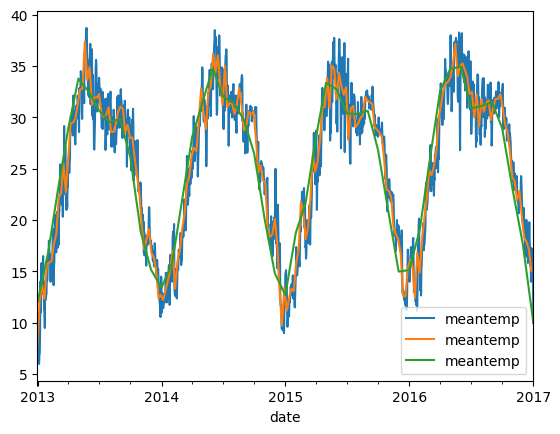

In [ ]:
#fig = px.line(df_train_d, x=ts.index, y='meantemp')
#fig.show()

ax1 = df_train_d.plot()
df_train_w.plot(ax=ax1)
df_train_m.plot(ax=ax1)

> By ploting the meantemp data over time, we can observe a seasonality pattern, with peaks in mean temperature by the middle of each year. This makes sense with the different seasons of the year and the expected increase in temperature for summer and spring. 

## Time Series Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

In [ ]:
plt.rcParams['figure.figsize'] = 20,3

result_daily = seasonal_decompose(df_train_d)
result_weekly = seasonal_decompose(df_train_w)
result_monthly = seasonal_decompose(df_train_m)

### Trend

<Axes: xlabel='date'>

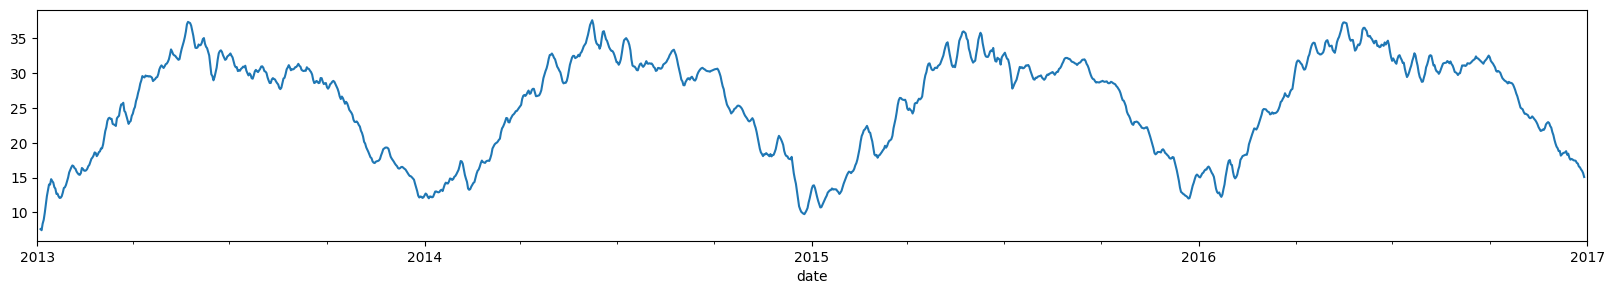

In [ ]:
result_daily.trend.plot()

<Axes: xlabel='date'>

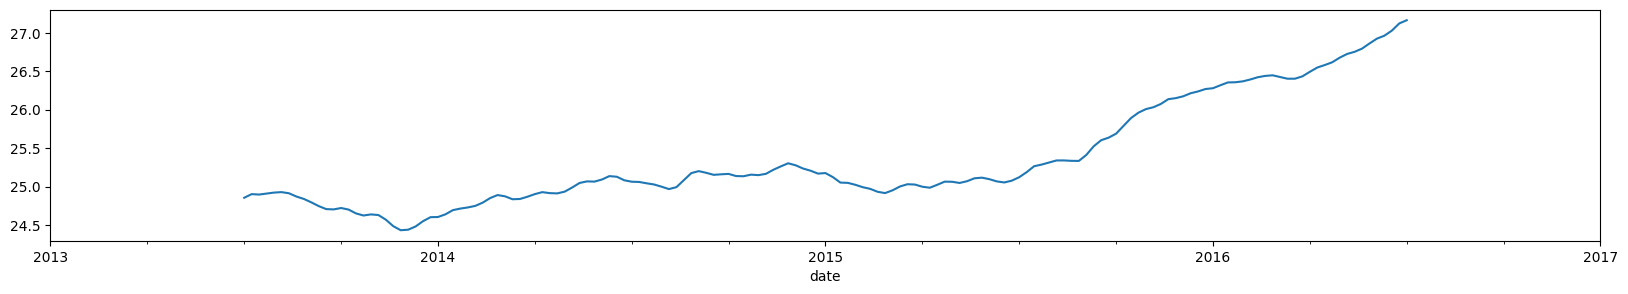

In [ ]:
result_weekly.trend.plot()

<Axes: xlabel='date'>

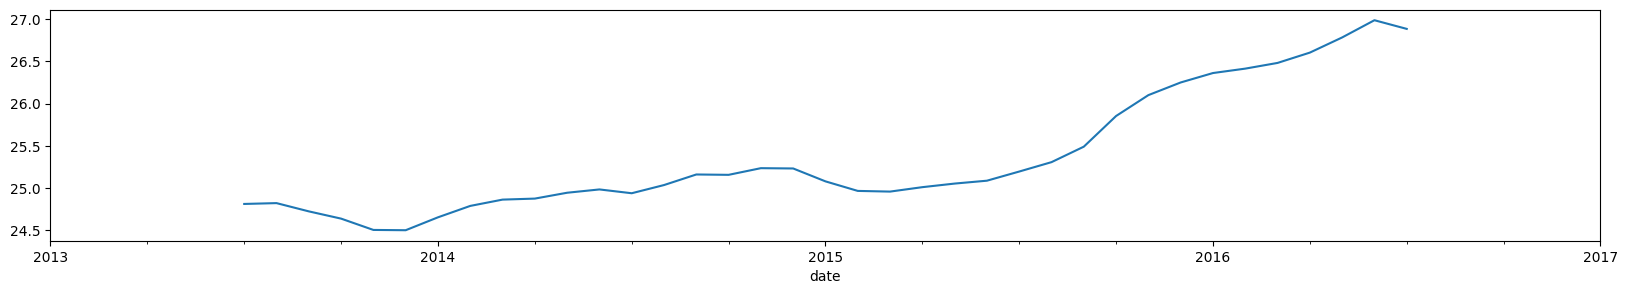

In [ ]:
result_monthly.trend.plot()

> We can see that when grouping the data by month and weeks a clear trend of increasing temperature over the years is revealed by the decomposition of the time series. The same does not happen when looking at the daily data, maybe because of the noise that the amount of observations introduce into the decomposition.

### Seasonal

<Axes: xlabel='date'>

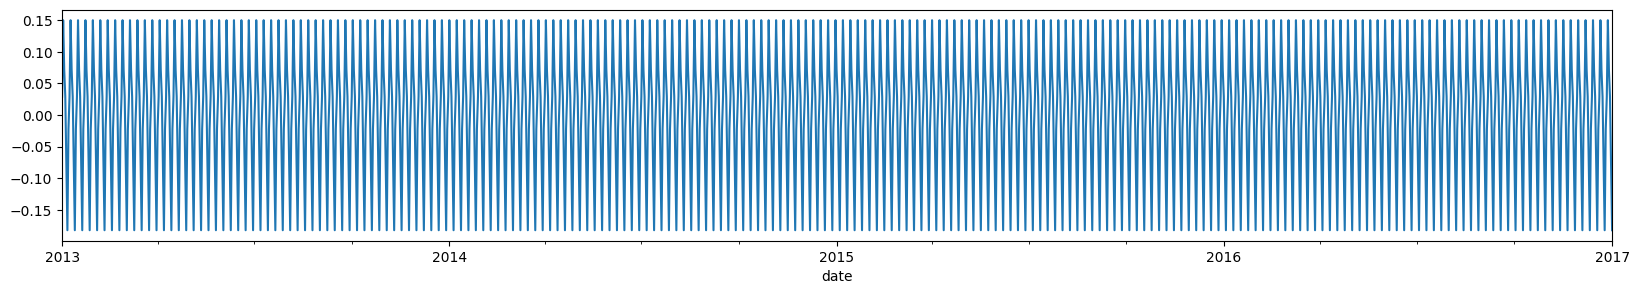

In [ ]:
result_daily.seasonal.plot()

<Axes: xlabel='date'>

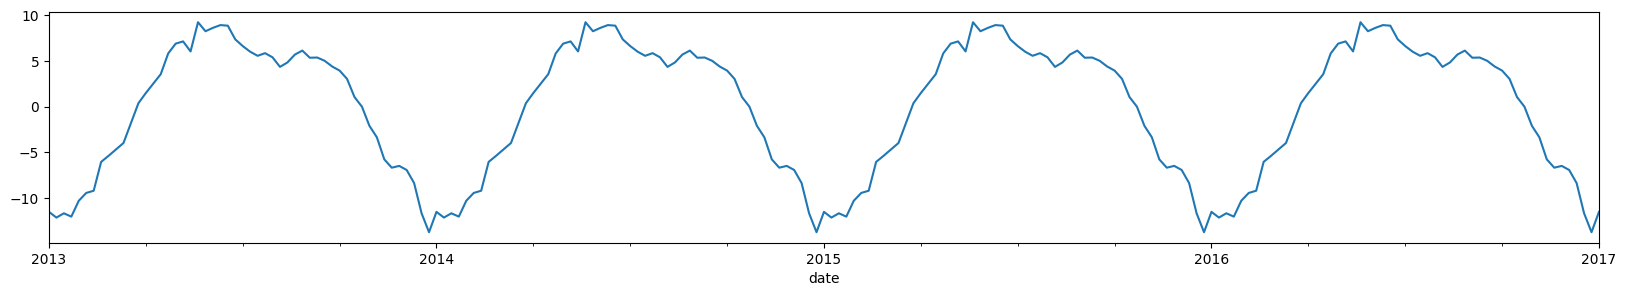

In [ ]:
result_weekly.seasonal.plot()

<Axes: xlabel='date'>

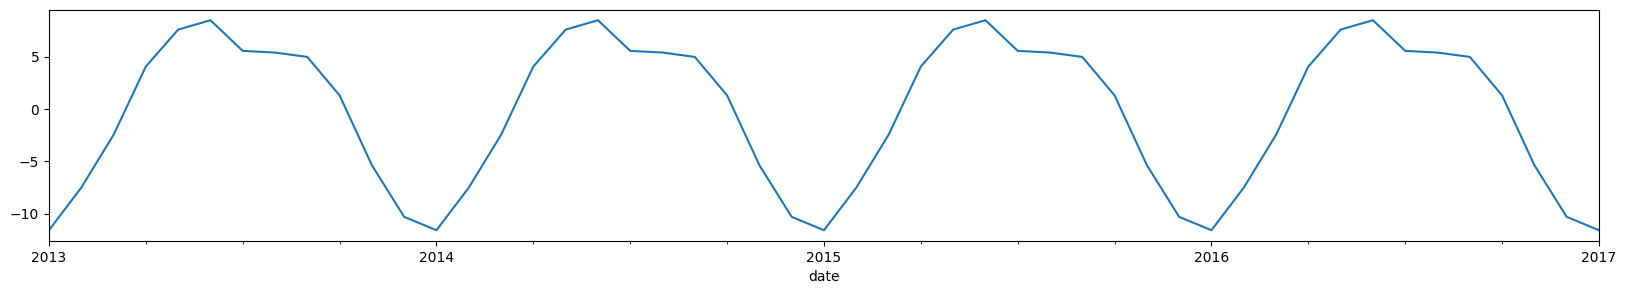

In [ ]:
result_monthly.seasonal.plot()

> The Seasonality of the data can also be clearly observed when looking at the grouped data. The daily data shows a "sinusoidal" like wave with a high frecuency of changes, while the monthly and weekly data reveal the actual seasonality of the changes in temperature over the progress of the year.

### Residual

<Axes: xlabel='date'>

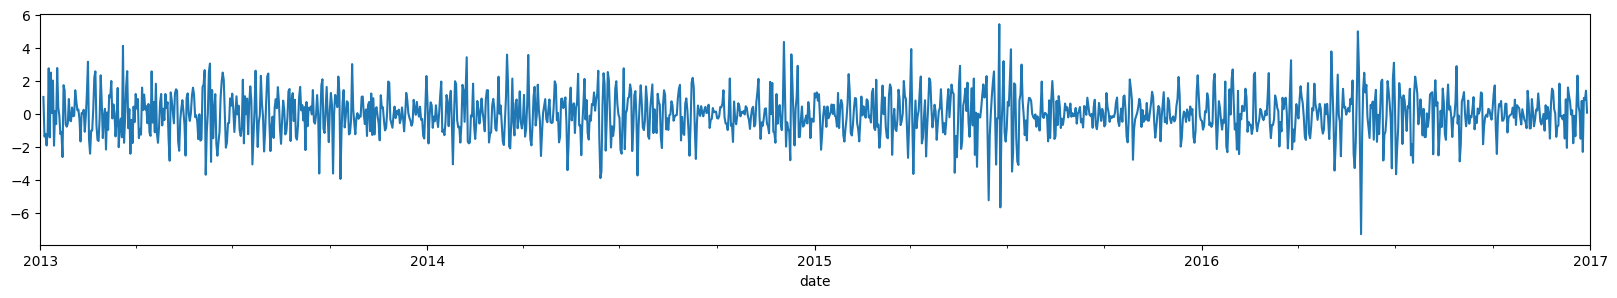

In [ ]:
result_daily.resid.plot()

<Axes: xlabel='date'>

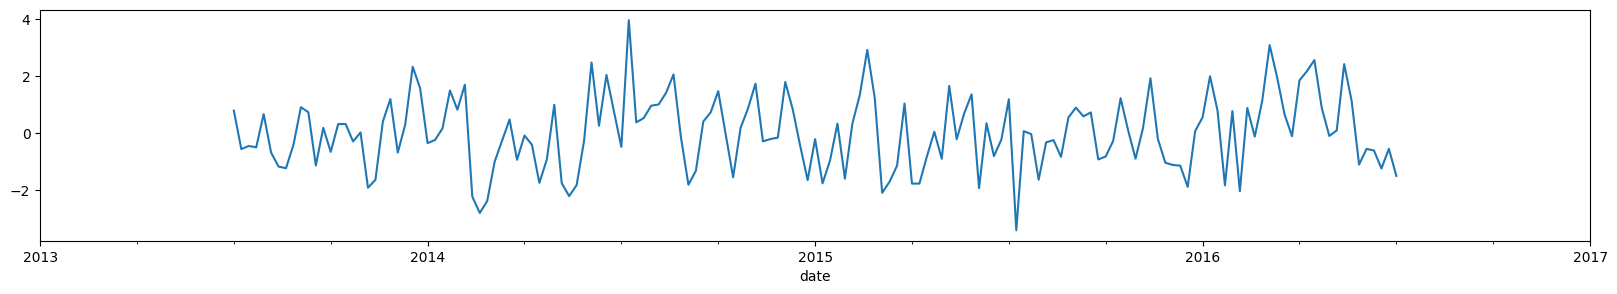

In [ ]:
result_weekly.resid.plot()

<Axes: xlabel='date'>

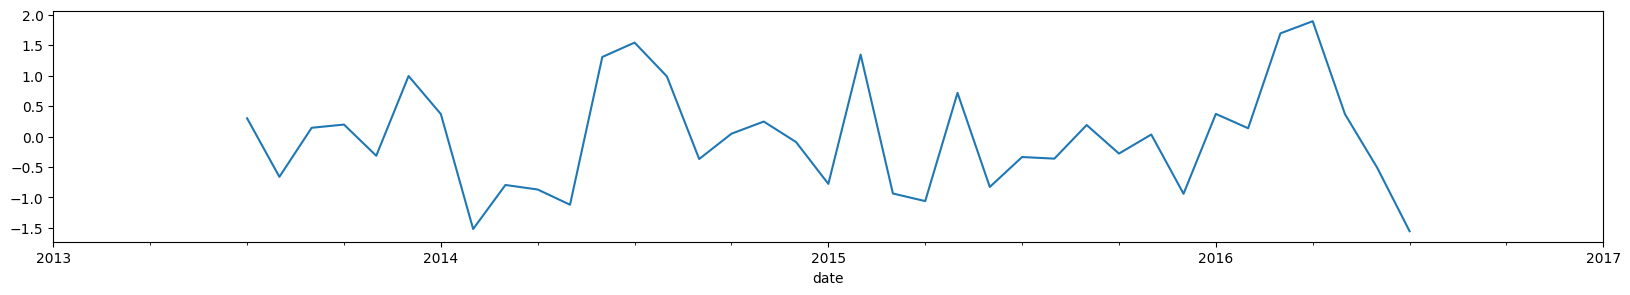

In [ ]:
result_monthly.resid.plot()

## Stationarity testing

> We also want to check (statistically) if our data is **stationary** (1), as it seems to be by looking at the plot.. We will use the **Augmented Dickey-Fuller (ADF)** test for this.

> If the test's p-value is below a chosen significance level (we are taking 0.05), we can reject the null hypothesis and conclude that the time series is stationary.

> _(1) This implies that the basic statisticall properties of the data distribution (such as the mean and variance) remain constant over time. Knowing this is usefull for future modelling._

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
  # Perform the ADF test
  result = adfuller(data)

  test_statistic = result[0]
  p_value = result[1]

  print(f"Test Statistic: {test_statistic}")
  print(f"P-value: {p_value}")
  print('ADF number of lags used:', result[2])
  print('ADF number of observations:', result[3])
  print('ADF critical values:', result[4])

  if p_value < 0.05:
    print("\n\n==> ✅ Data is stationary.")
  else:
    print("\n\n==> ❌ Data cannot be proven to be stationary. You should apply diferentiation for statisticall modelling")

In [ ]:
adf_test(df_train_d)

Test Statistic: -2.0210690559206737
P-value: 0.2774121372301601
ADF number of lags used: 10
ADF number of observations: 1451
ADF critical values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


==> ❌ Data cannot be proven to be stationary. You should apply diferentiation for statisticall modelling


In [ ]:
adf_test(df_train_w)

Test Statistic: -4.745758091420333
P-value: 6.898378388762698e-05
ADF number of lags used: 6
ADF number of observations: 202
ADF critical values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}


==> ✅ Data is stationary.


In [ ]:
adf_test(df_train_m)

Test Statistic: -1.0462204206798933
P-value: 0.7360356050589151
ADF number of lags used: 10
ADF number of observations: 38
ADF critical values: {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}


==> ❌ Data cannot be proven to be stationary. You should apply diferentiation for statisticall modelling


> We are going to differentitate the daily and monthly data to get a stationary series for modelling.

In [ ]:
diff_daily = df_train_d.diff().dropna()
diff_monthly = df_train_m.diff().dropna()

> Let's test again to see if we have achieved the desired stationarity..

In [ ]:
adf_test(diff_daily)

Test Statistic: -16.378720267074673
P-value: 2.764863137594644e-29
ADF number of lags used: 9
ADF number of observations: 1451
ADF critical values: {'1%': -3.4348647527922824, '5%': -2.863533960720434, '10%': -2.567831568508802}


==> ✅ Data is stationary.


In [ ]:
adf_test(diff_monthly)

Test Statistic: -7.275868440106254
P-value: 1.545072980597148e-10
ADF number of lags used: 9
ADF number of observations: 38
ADF critical values: {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}


==> ✅ Data is stationary.


> Great! By differentiating once we have achieved stationarity and we can now model our data with models that have this requirements such as ARIMA variants.

# 3. Statistical Modelling: AutoArima

Autoarima automatically chooses the best values for the model's parameters p, d and q, where:

* p is the number of autoregressive terms
* d is the number of nonseasonal differences,
* q is the number of lagged forecast errors in the prediction equation.

The **seasonal** parameter of the autoarima model has the following impact depending on its value:

- False: If seasonal=False, it indicates that the function should not consider seasonality in the data. The resulting ARIMA model will only capture the non-seasonal components, such as trend and irregular fluctuations.
- True: If seasonal=True, it indicates that the function should consider seasonality in the data. The resulting ARIMA model will incorporate both the non-seasonal and seasonal components, allowing for capturing and forecasting the seasonal patterns in the time series.

💡 Note that AUTOARIMA automatically decides de degree of differentitation needed (d parameter) for each series to be stationary, so we can just pass the function the original data for each grouping.

In [ ]:
performance = {}

## Apllying the model without seasonality:

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def train_auto_arima(train, test, modelname,seasonality = False, number_of_periods = 0, differentiated = False, original_data = None):
  # create and train the model
  if seasonality:
    print("> Training the model with seasonality")
    if number_of_periods != 0:
      model_arima = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonality= True, m = number_of_periods)
    else:
      model_arima = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonality= True)
  else:
    model_arima = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
  
  model_arima.fit(train)

  # forecast
  forecast_arima = model_arima.predict(n_periods= len(test))
  forecast_arima = pd.DataFrame(forecast_arima, index = test.index, columns=['ARIMA forecast'])

  # if the model was trained on differentiated data, then the forecasts need to be re-transformed to the original scale of the data by the following operation:
  if differentiated:
    initial_value = original_data["meantemp"][-1]  # Initial or base value of the original data (traindataset)
    forecast_arima = train["meantemp"].iloc[-1] + forecast_arima.cumsum() + initial_value

  # output the plot of the prediction
  plt.rcParams['figure.figsize'] = 20,3
  if differentiated:
    ax1 = original_data.plot()
  else:
    ax1 = train.plot()
  test.plot(ax=ax1)
  forecast_arima.plot(ax=ax1)

  # metrics
  forecast_arima = forecast_arima.fillna(forecast_arima.mean())

  print('\nARIMA auto MSE:', round(mean_squared_error(test, forecast_arima),2))
  print('ARIMA auto MAE:', round(mean_absolute_error(test, forecast_arima),3), "\n")

  performance[modelname] = [round(mean_squared_error(test, forecast_arima),2), round(mean_absolute_error(test, forecast_arima),2)]
  

### Daily data

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5546.314, Time=5.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5650.181, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5614.068, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5602.114, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5648.181, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5546.168, Time=1.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5573.723, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5544.460, Time=1.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5546.100, Time=1.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5600.849, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5542.478, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5600.115, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5612.068, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5544.118, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0]          

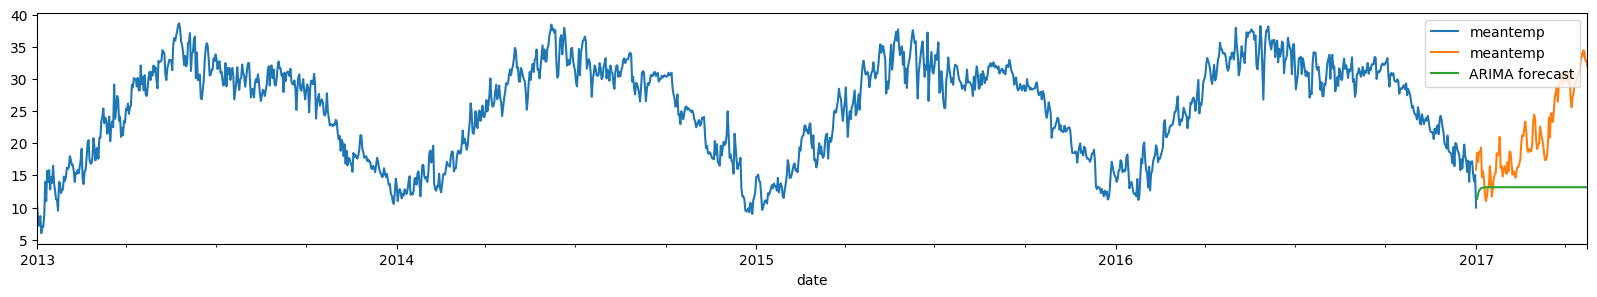

In [ ]:
# remember that daily data was differentitated but autoarima takes care automatically about this
train_auto_arima(df_train_d, df_test_d, modelname="Daily auto ARIMA NS")

### Weekly data

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=861.129, Time=1.86 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1422.446, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=900.013, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1221.251, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1964.675, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=899.102, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=902.784, Time=0.86 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=901.746, Time=2.34 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=902.345, Time=1.29 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=901.774, Time=0.44 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=899.725, Time=1.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=859.008, Time=3.97 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=898.223, Time=0.48 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=858.783, Time=2.50 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=89

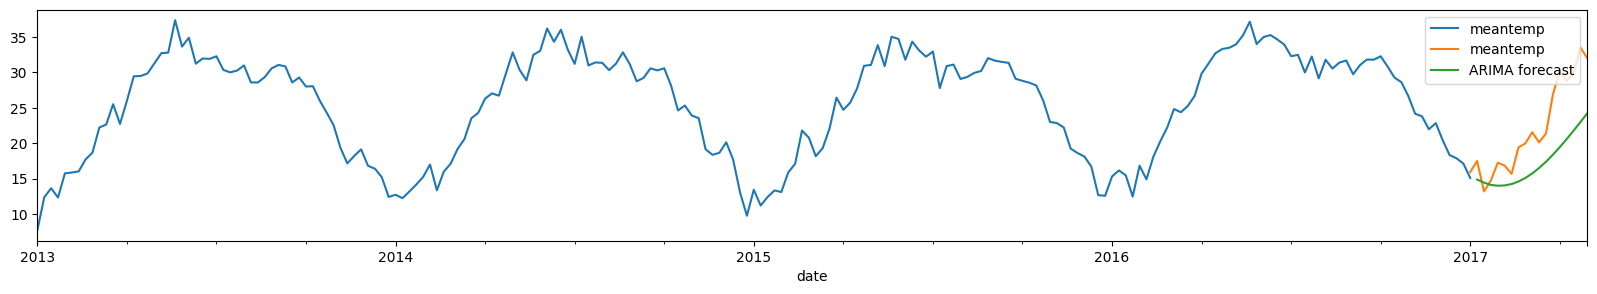

In [ ]:
# weekly data didnt need differentitation
train_auto_arima(df_train_w, df_test_w, modelname = "Weekly auto ARIMA NS")

### Monthly data

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=231.045, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=336.992, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=285.488, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=295.017, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=461.037, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=251.919, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=234.108, Time=0.62 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=238.070, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=231.277, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=262.483, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=249.854, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=231.184, Time=0.35 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=235.362, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=254.650, Time=0.09 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept


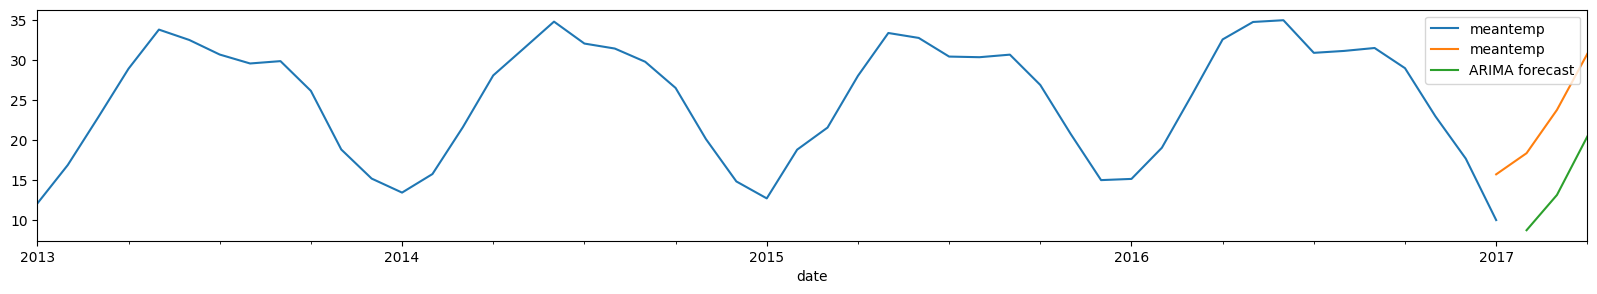

In [ ]:
# monthly data was differentitated, handled by autoarima
train_auto_arima(df_train_m, df_test_m, modelname="Monthly auto ARIMA NS")

### About ARIMA (No Seasonality)

> The prediction from the **daily** ARIMA model is really bad, we see that the model outputs a constant line for the test period (green line), when the real data is far from being constant (orange line). 

> For the **monthly** grouped data we see that the metrics are even worse, with the modell failling to predict for such a short amount of data points (by grouping by month we are "loosing" data points).

> The weekly approach is the best one in terms of predicting the test period. Nevertheless, it has still plenty of room for improvement since it is somehow able to predict the trend of the data but not the "regional" spikes in the period.

## Applying the model with Seasonality

*Training ARIMA with seasonality requires us to pass an aditional parameter "M" wich is used to specify the seasonal period in seasonal ARIMA models. It helps the auto_arima function determine the appropriate seasonal differencing and select the optimal seasonal ARIMA model.*

*For example, if your time series data exhibits monthly seasonality, you would set m=12 to indicate that there are 12 observations in each seasonal cycle (12 months in a year). Similarly, if your data exhibits quarterly seasonality, m would be set to 4.*

💡 Autoarima takes care of this decision as well, but we can specify it if we want to try to get better results.

### Daily Data

In [ ]:
#train_auto_arima(df_train_d, df_test_d, seasonality = True, number_of_periods= 365, modelname = "Daily auto ARIMA S")

> The model with seasonality for daily data took too long to execute. We weren't able to study the effects of this parameter on this particular grouping.

### Weekly Data

> Training the model with seasonality
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=18.91 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1422.446, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=894.427, Time=4.91 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1964.675, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=900.013, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=893.796, Time=14.55 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=82.98 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=12.45 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=37.08 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=891.595, Time=20.33 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=893.537, Time=3.72 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=61.70 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=13.74 sec
 ARIMA(3,0,0)

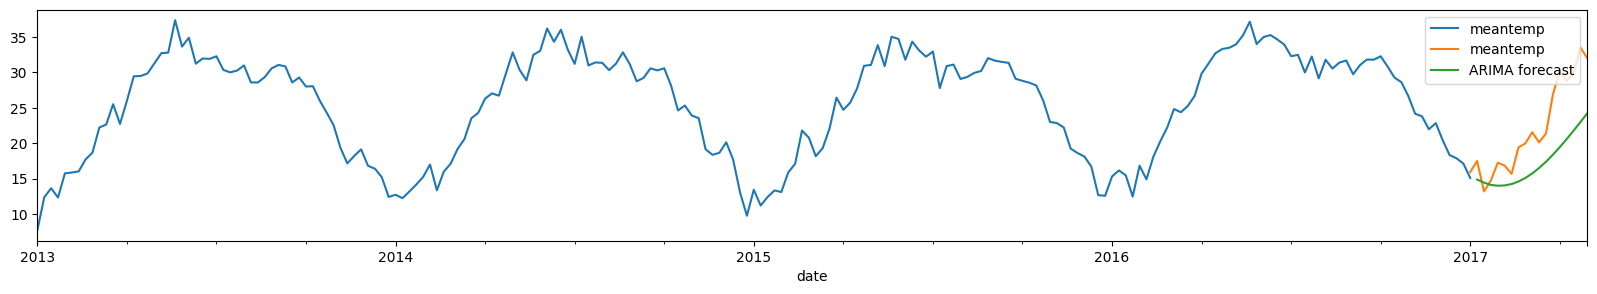

In [ ]:
train_auto_arima(df_train_w, df_test_w, seasonality = True, number_of_periods = 52, modelname = "Weekly auto ARIMA S")

> Note that on weekly data, even though the model was trained with seasonality, auto arima chose a model that didn't take this into account. (the same model as with no seasonality)

### Monthly Data

> Training the model with seasonality
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=154.686, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=147.633, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=156.606, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=155.971, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=147.522, Time=0.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=149.432, Time=0.68 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=147.497, Time=0.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=149.432, Time=0.76 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=147.449, Time=0.44 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=148.932, Time=0.28 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(1,0,

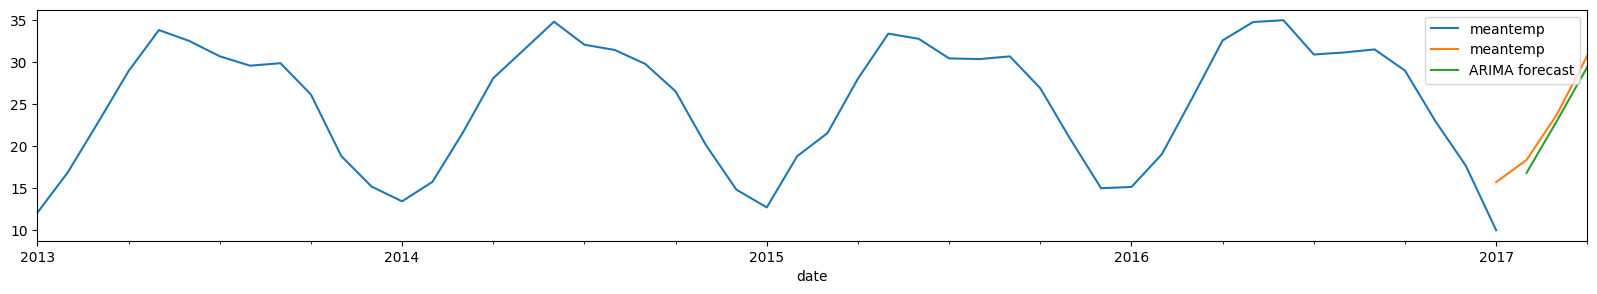

In [ ]:
train_auto_arima(df_train_m, df_test_m, seasonality = True, number_of_periods = 12, modelname = "Monthly auto ARIMA S")

> In monthly data, even though the prediction is not good, it improved over the monthly one without seasonality. It would be great to train the first daily model with seasonality in a more powerfull cloud environment to analyze the impacts on prediction.

# 4. Applying Exponential Smoothing

*Exponential smoothing is a time series forecasting technique that assigns exponentially decreasing weights to past observations. It is commonly used to capture and forecast trends and patterns in time series data. The basic idea behind exponential smoothing is to give more importance to recent observations while progressively decreasing the weight assigned to older observations.*

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def expo_smooth(train, test, seasonal_periods, modelname):
  # Simple expo smoothing
  model = ExponentialSmoothing(train)
  fitted_model = model.fit()
 
  forecast_length = len(test)
  predictions = fitted_model.predict(start=len(train), end=len(train) + forecast_length - 1)
  forecast_expon = pd.DataFrame(predictions, index = test.index,columns=['Exponentional Smoothing'])

  ax1 = train.plot()
  test.plot(ax=ax1)
  forecast_expon.plot(ax=ax1)
  forecast_expon = forecast_expon.fillna(forecast_expon.mean())

  print('\nSimpleES MSE:', round(mean_squared_error(test, forecast_expon),2))
  print('SimpleES MAE:', round(mean_absolute_error(test, forecast_expon),3), "\n")
  
  performance[modelname + " SimpleES"] = [round(mean_squared_error(test, forecast_expon),2), round(mean_absolute_error(test, forecast_expon),3)]

  # Adding Trend
  model = ExponentialSmoothing(train, trend='add')
  fitted_model = model.fit()
 
  forecast_length = len(test)
  predictions = fitted_model.predict(start=len(train), end=len(train) + forecast_length - 1)
  forecast_expon = pd.DataFrame(predictions, index = test.index,columns=['Exponentional Smoothing with Trend'])

  ax1 = train.plot()
  test.plot(ax=ax1)
  forecast_expon.plot(ax=ax1)
  forecast_expon = forecast_expon.fillna(forecast_expon.mean())

  print('\nTrendES MSE:', round(mean_squared_error(test, forecast_expon),2))
  print('TrendES MAE:', round(mean_absolute_error(test, forecast_expon),3), "\n")

  performance[modelname + " TrendES"] = [round(mean_squared_error(test, forecast_expon),2), round(mean_absolute_error(test, forecast_expon),3)]


  # Fit triple exponential smoothing model (Holt-Winters' method)
  if seasonal_periods != 0:
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
  else:
    model = ExponentialSmoothing(train, trend='add', seasonal='add')
  fitted_model = model.fit()
 
  forecast_length = len(test)
  predictions = fitted_model.predict(start=len(train), end=len(train) + forecast_length - 1)
  forecast_expon = pd.DataFrame(predictions, index = test.index,columns=['Triple Exponentional Smoothing'])

  ax1 = train.plot()
  test.plot(ax=ax1)
  forecast_expon.plot(ax=ax1)
  forecast_expon = forecast_expon.fillna(forecast_expon.mean())

  print('\nTripleES MSE:', round(mean_squared_error(test, forecast_expon),2))
  print('TripleES MAE:', round(mean_absolute_error(test, forecast_expon),3), "\n")

  performance[modelname + " TripleES"] = [round(mean_squared_error(test, forecast_expon),2), round(mean_absolute_error(test, forecast_expon),3)]



### Daily Data

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



SimpleES MSE: 153.17
SimpleES MAE: 10.635 


TrendES MSE: 151.37
TrendES MAE: 10.57 



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



TripleES MSE: 11.93
TripleES MAE: 2.747 



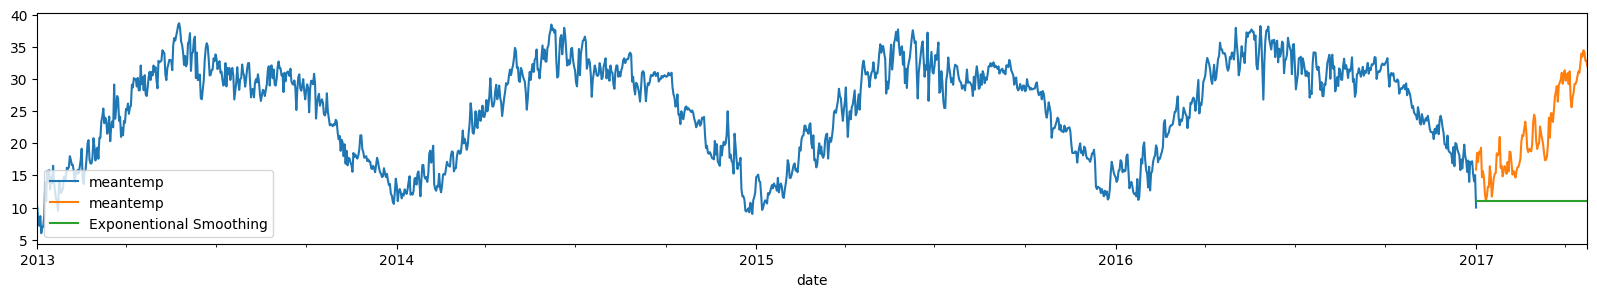

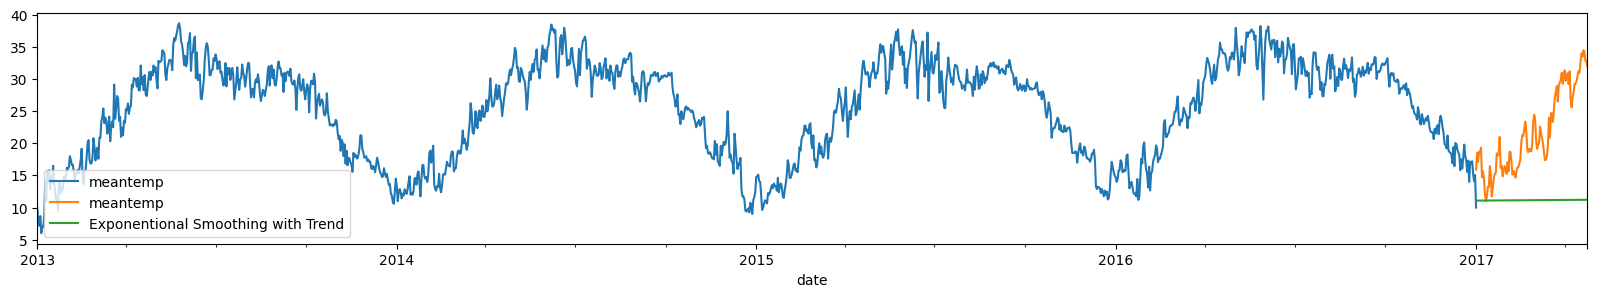

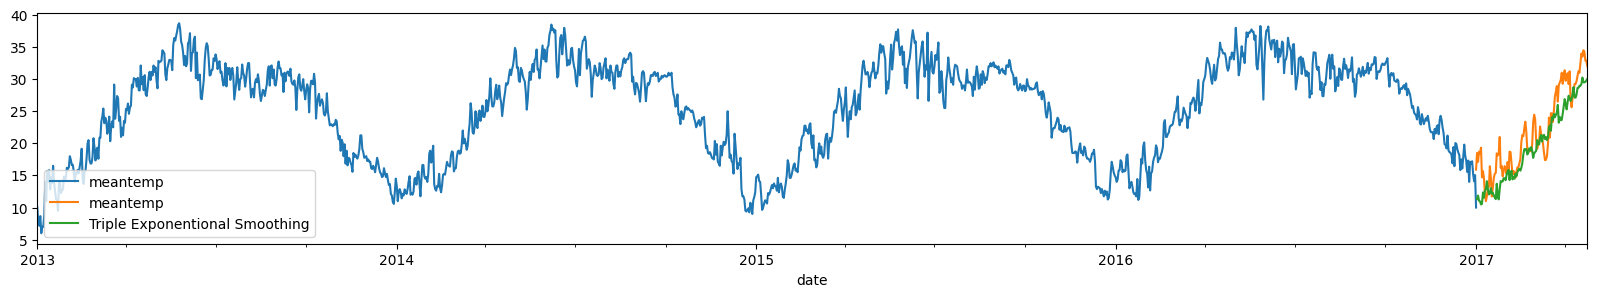

In [ ]:
expo_smooth(df_train_d, df_test_d, seasonal_periods= 365, modelname = "Daily") # 365 days in a year, lenght of the "season"

### Weekly Data


SimpleES MSE: 85.84
SimpleES MAE: 7.026 


TrendES MSE: 467.76
TrendES MAE: 17.944 


TripleES MSE: 14.91
TripleES MAE: 3.257 



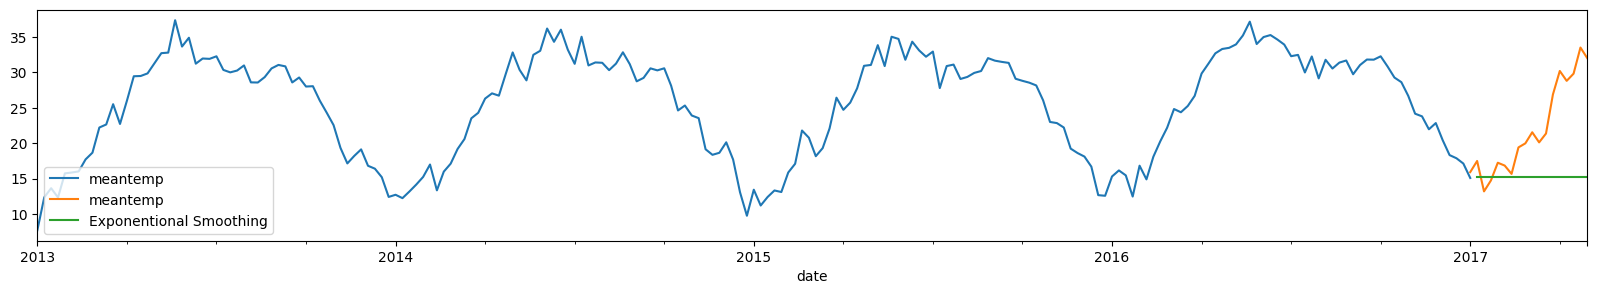

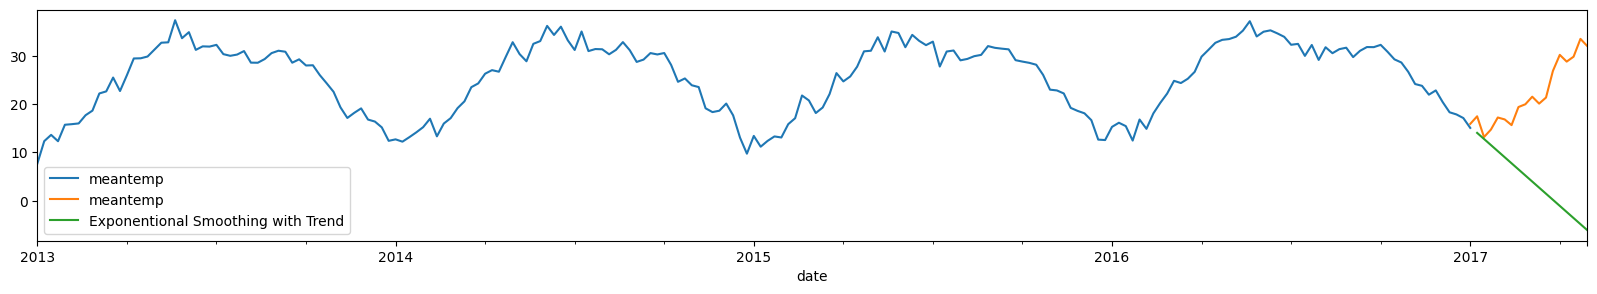

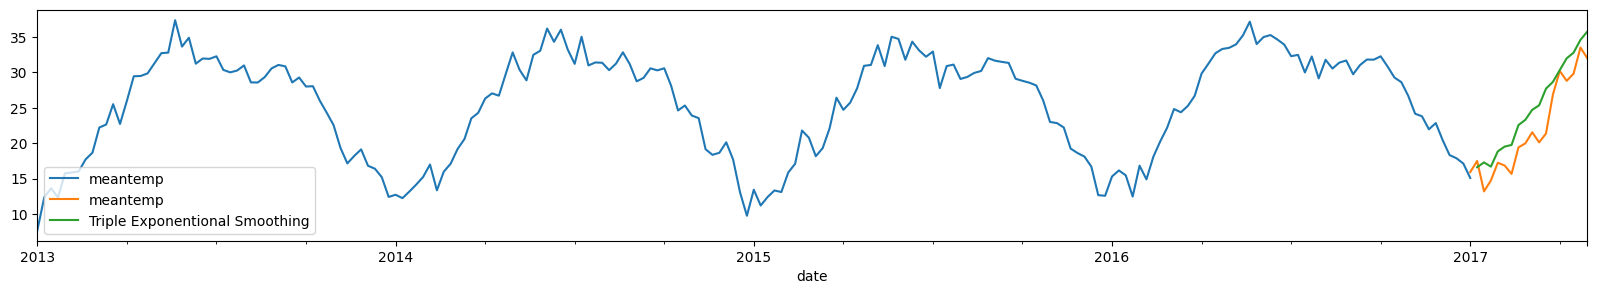

In [ ]:
expo_smooth(df_train_w, df_test_w, seasonal_periods= 52, modelname = "Weekly") # 52 weeks in a year, lenght of the "season"

### Monthly Data


SimpleES MSE: 180.55
SimpleES MAE: 12.142 


TrendES MSE: 865.69
TrendES MAE: 27.487 


TripleES MSE: 20.34
TripleES MAE: 2.549 



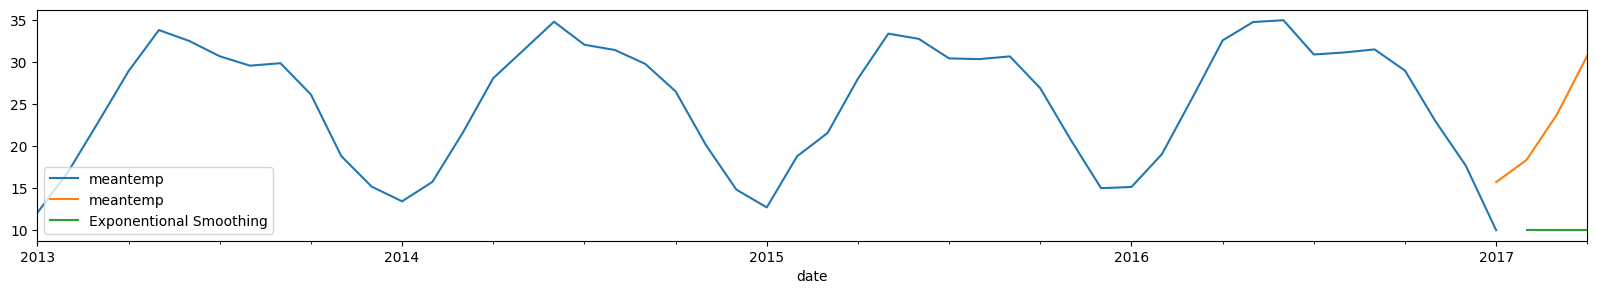

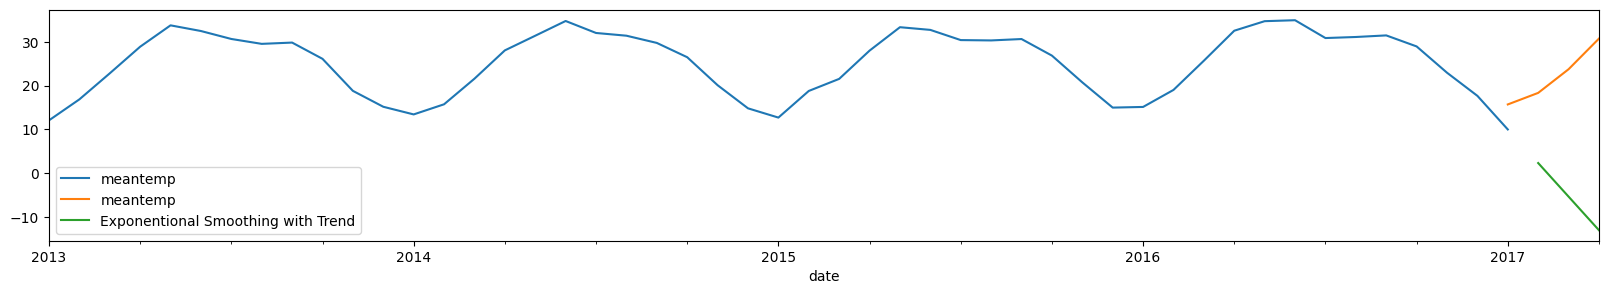

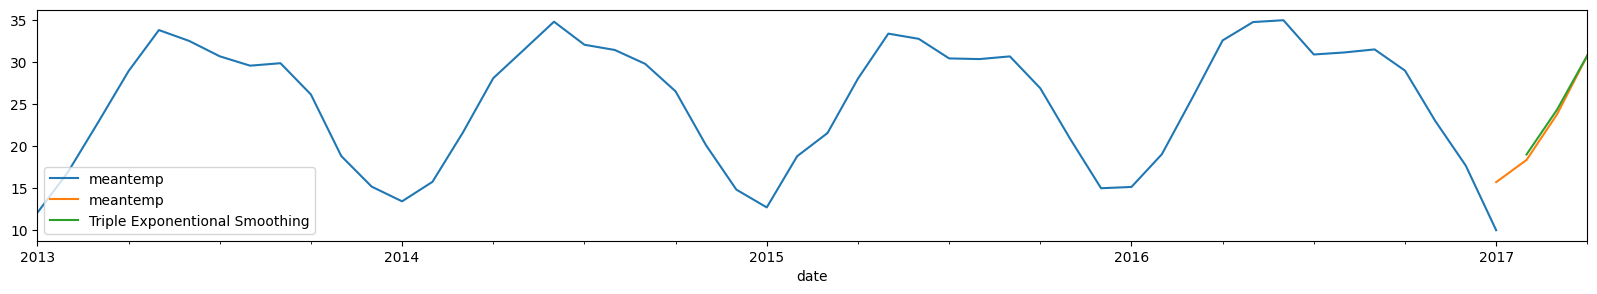

In [ ]:
expo_smooth(df_train_m, df_test_m, seasonal_periods= 12, modelname = "Monthly") # 365 days in a year, lenght of the "season"

> For the three grouping cases, the triple exponential smoothing (considers trend and seasonality) is the best performer.

In [ ]:
performance

{'Daily auto ARIMA NS': [113.48, 8.69],
 'Weekly auto ARIMA NS': [35.13, 5.01],
 'Monthly auto ARIMA NS': [78.56, 8.04],
 'Weekly auto ARIMA S': [35.13, 5.01],
 'Monthly auto ARIMA S': [14.73, 2.75],
 'Daily SimpleES': [153.17, 10.635],
 'Daily TrendES': [151.37, 10.57],
 'Daily TripleES': [11.93, 2.747],
 'Weekly SimpleES': [85.84, 7.026],
 'Weekly TrendES': [467.76, 17.944],
 'Weekly TripleES': [14.91, 3.257],
 'Monthly SimpleES': [180.55, 12.142],
 'Monthly TrendES': [865.69, 27.487],
 'Monthly TripleES': [20.34, 2.549]}

# 5. Lag Features and ML Modelling

*The lag features approach is a common technique used in time series analysis to incorporate the historical values of a time series as features in a predictive model. It involves creating new features by lagging the original time series data*. 

*In the lag features approach, the value of the time series at previous time steps (lags) is used as input features for predicting the value at the current time step. By including lagged values as features, the model can capture temporal dependencies and patterns in the data.*

In [ ]:
daily_df = pd.concat([df_train_d, df_test_d])
weekly_df = pd.concat([df_train_w, df_test_w])
monthly_df = pd.concat([df_train_m, df_test_m])

### Daily data

In [ ]:
daily_sliding_window = 10
sliding_window = daily_sliding_window

In [ ]:
def create_lag_features(df, sliding_window):
  # shifting to create simple lagged features
  for window_size in range(0, sliding_window):
      df[f'Lag_{window_size+1}'] = df.meantemp.shift(window_size+1)
  # drop the first [sliding_window_length] rows since they have NAN values.
  df = df.drop(df.index[:sliding_window])
  return df

def create_non_linear_lag_features(df, sliding_window):
  # shifting to create simple lagged features
  for window_size in range(0,sliding_window):
      df[f'Lag_{window_size+1}'] = df.meantemp.shift(window_size+1)
  # drop the first [sliding_window_length] rows since they have NAN values.
  df = df.drop(df.index[:sliding_window])
  for window_size in range(0,sliding_window):
    df[f'Lag_yeardiff_{window_size}'] = df.meantemp.shift(365+window_size) 
  # drop the first year since it doesnt have a "previous" year in the data
  df = df.drop(df.index[:365])
  return df


In [ ]:
lagged_daily = create_lag_features(daily_df, sliding_window)
lagged_daily.head()

,meantemp,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10
date,,,,,,,,,,,
2013-01-11,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-12,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
2013-01-13,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
2013-01-14,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
2013-01-15,14.714286,12.833333,15.833333,14.000000,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000


> Training a simple regressor on the lagged features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def train_regressor(data, modelname):
  # TTsplit
  y = data["meantemp"]
  X = data.drop("meantemp", axis =1 )
  # "test range" were the last 114 days of the dataset
  X_train = X[:len(X)-114]
  X_test = X[-114:]
  y_train = y[:len(X)-114]
  y_test = y[-114:]
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # create and train the model
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  mse = round(mean_squared_error(y_test, y_pred),2)
  mae = round(mean_absolute_error(y_test, y_pred),3)
  print(modelname, ' MSE:',mse )
  print('ARIMA auto MAE:', mae, "\n")

  performance[modelname] = [mse, mae]

  plt.rcParams['figure.figsize'] = 15,3

  ax1 = y_train.plot()
  y_test.plot(ax=ax1)
  y_pred = pd.DataFrame(y_pred, index = X_test.index, columns=['Forecast'])
  y_pred.plot(ax=ax1)

Lagged features LR daily  MSE: 3.05
ARIMA auto MAE: 1.387 



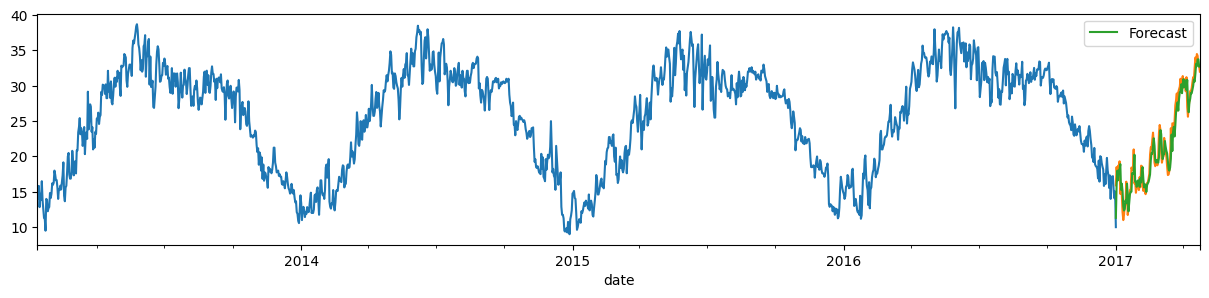

In [ ]:
train_regressor(lagged_daily, "Lagged features LR daily")

> We are going to add the values of the lags for the previous N days, but of the last year to see if that improves performance

### Week Data

Lagged features LR weekly  MSE: 4.15
ARIMA auto MAE: 1.649 



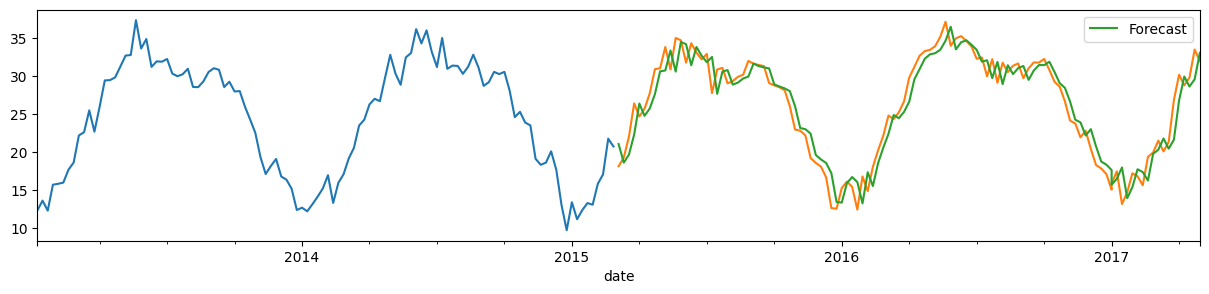

In [ ]:
weekly_sliding_window = 1
sliding_window = weekly_sliding_window
lagged_weekly = create_lag_features(weekly_df, sliding_window)
train_regressor(lagged_weekly, "Lagged features LR weekly")


### Monthly Data

In [ ]:
monthly_sliding_window = 1
sliding_window = monthly_sliding_window
lagged_monthly = create_lag_features(monthly_df, sliding_window)
#train_regressor(lagged_monthly, "Lagged features LR monthly")

> Training on monthly data is not possible since we have very few data points.

### About simple ML

Improvement in performance is quite good. We could also add non linear windows, like adding the values for the same day but from the previous years, and study the impact on the performance.

# 6. Adding additional features to our ML model

The idea here is to add to the lag features, the "included" features of each data point (the remaining columns of the original dataset). We are going to do this only with the daily data since it was the best performing of all the groupings.

Lagged Ml with extra features daily  MSE: 2.84
ARIMA auto MAE: 1.356 



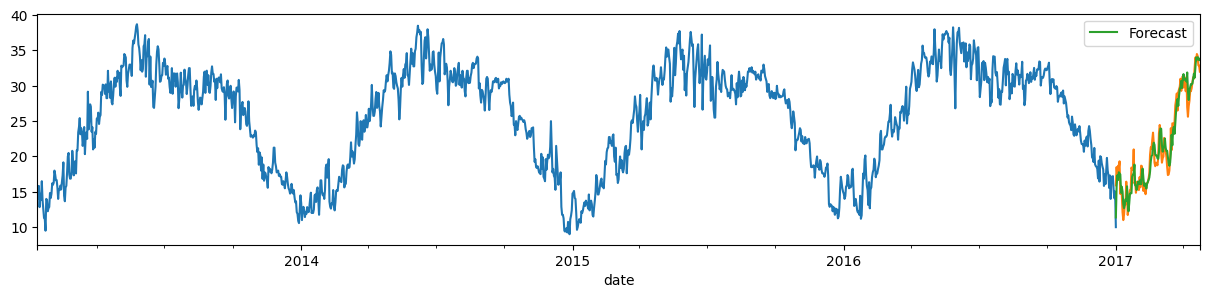

In [ ]:
df_train_d_full = df_train
df_test_d_full = df_test
full = pd.concat([df_train_d_full,df_test_d_full])
daily_df_full_lagged = create_lag_features(full, sliding_window=10)
train_regressor(daily_df_full_lagged, "Lagged Ml with extra features daily")

> Adding new features improved our errors. Lets try changing the length of the window as well

Lagged Ml with extra features daily  MSE: 2.92
ARIMA auto MAE: 1.336 



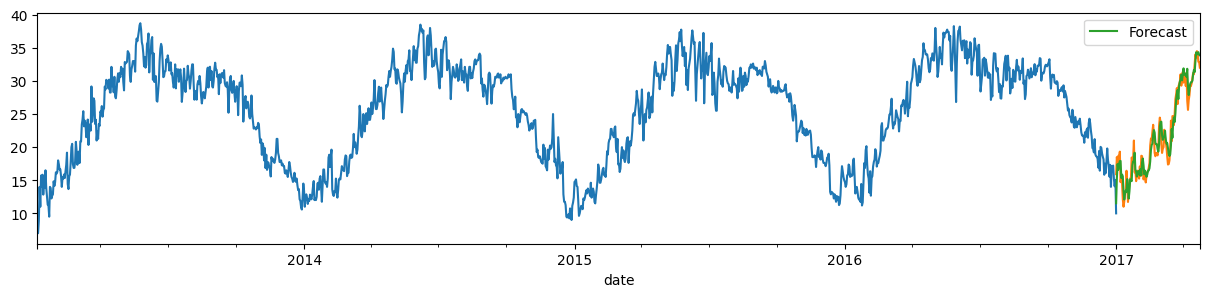

In [ ]:
df_train_d_full = df_train
df_test_d_full = df_test
full = pd.concat([df_train_d_full,df_test_d_full])
daily_df_full_lagged = create_lag_features(full, sliding_window=5)
train_regressor(daily_df_full_lagged, "Lagged Ml with extra features daily")

Lagged Ml with extra features daily  MSE: 2.86
ARIMA auto MAE: 1.346 



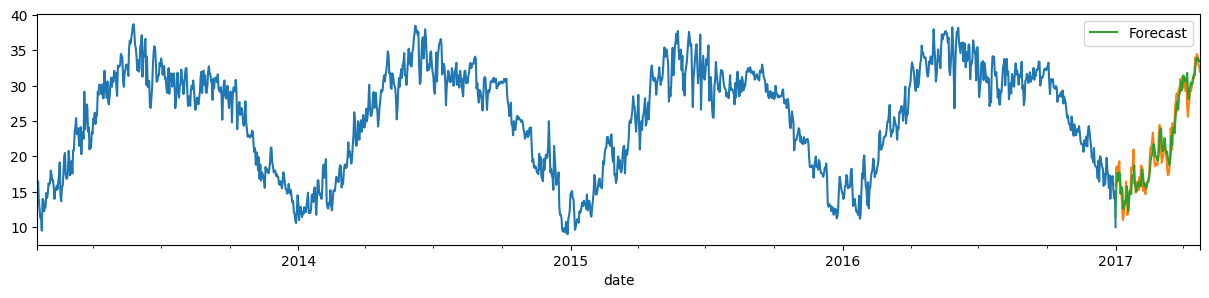

In [ ]:
df_train_d_full = df_train
df_test_d_full = df_test
full = pd.concat([df_train_d_full,df_test_d_full])
daily_df_full_lagged = create_lag_features(full, sliding_window=15)
train_regressor(daily_df_full_lagged, "Lagged Ml with extra features daily")

Lagged Ml with extra features daily  MSE: 2.78
ARIMA auto MAE: 1.253 



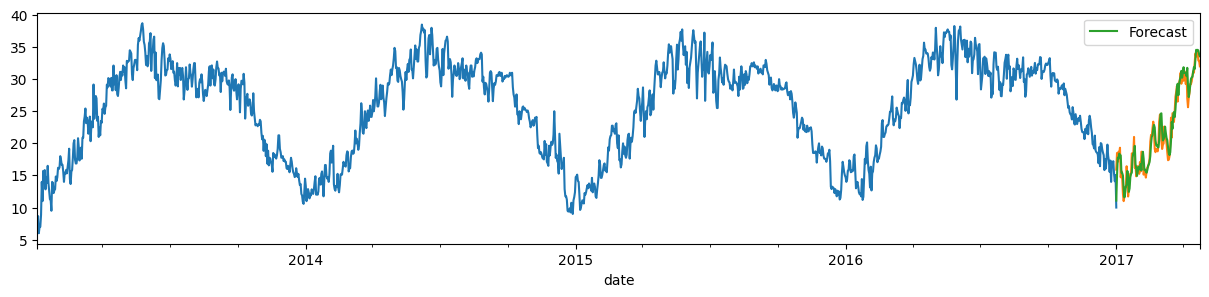

In [ ]:
df_train_d_full = df_train
df_test_d_full = df_test
full = pd.concat([df_train_d_full,df_test_d_full])
daily_df_full_lagged = create_lag_features(full, sliding_window=2)
train_regressor(daily_df_full_lagged, "Lagged Ml with extra features daily")

We seem to get a better performance with a smaller window. This could be further studied in the future 🧐

# Conclusions

After testing different approaches to predict time series data, we were exposed to different modelling techniques and learned a lot about them. 

We found out, that for our specific data, the ML model with aditional features and a small window was the best performer. 

Further improvements could be made by applying non linear sliding windows, adding more features (feature engineering) and stuying the optimal window size for the model.

Also, we discovered that for statistical approaches, models that didn't included seasonality performed very poorly compared to the ones that did.

Next, we plot a performance chart of the different tested models:

In [ ]:
mses = []
maes = []

for key in performance.keys():
  mses.append(performance[key][0])
  maes.append(performance[key][1])

In [ ]:
import plotly.graph_objects as go

# Create a bar trace
trace = go.Bar(
    x = list(performance.keys()),  # List of names as x-axis values
    y = mses,
    text=mses,  # List of values for displaying on the bars
    textposition='auto'  # List of values as y-axis values
)

# Create the layout
layout = go.Layout(
    title='Performance based on MSE',
    xaxis=dict(title='Model'),
    yaxis=dict(title='Value'),
    
)

# Create the figure
figure = go.Figure(data=[trace], layout=layout)

# Display the figure
figure.show()


In [ ]:
# Create a bar trace
trace = go.Bar(
    x = list(performance.keys()),  # List of names as x-axis values
    y = maes,
    text=maes,  # List of values for displaying on the bars
    textposition='auto'  # List of values as y-axis values
)

# Create the layout
layout = go.Layout(
    title='Performance based on MAE',
    xaxis=dict(title='Model'),
    yaxis=dict(title='Value'),
    
)

# Create the figure
figure = go.Figure(data=[trace], layout=layout)

# Display the figure
figure.show()
